# Predizione dei Consumi Energetici nell'Industria Siderurgica

**Studente**: Massimiliano Camillucci  
**Matricola**: 0001087333  
**Corso**: Programmazione di Applicazioni Data Intensive A.A. 2024/2025

## Dataset ##
**Dataset utilizzato**: Steel Industry Energy Consumption (Kaggle/UCI Repository)
- **35.040 misurazioni** prese ogni 15 minuti per 6 mesi
- **Obiettivo**: prevedere `Usage_kWh` (quanta energia viene consumata)
- **10 variabili** che descrivono lo stato dell'impianto
- **Link**: https://www.kaggle.com/datasets/csafrit2/steel-industry-energy-consumption

## Descrizione del Problema
In questo progetto analizziamo i dati di consumo energetico di un'industria siderurgica per creare un modello che possa **prevedere quanto energia verrà consumata** in base alle condizioni operative dell'impianto.

**Applicazioni potenziali**
- Supporto nel pianificare  la produzione
- Ottimizzare i costi energetici
- Ridurre gli sprechi di energia

**Cosa misuriamo**:
- **Variabili numeriche**: potenze elettriche, fattori di efficienza, emissioni CO2
- **Variabili categoriche**: tipo di lavorazione, giorno della settimana, se è weekend

Il nostro compito è capire **quali fattori influenzano di più** il consumo energetico e costruire un modello accurato per le previsioni.

## 1. Caricamento e Descrizione Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('Steel_industry_data.csv')
print(f"Dataset caricato! Dimensioni: {df.shape[0]} righe  {df.shape[1]} colonne")
df.info()
df.head()

Dataset caricato! Dimensioni: 35040 righe  11 colonne
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                   

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [2]:
print("STATISTICHE")
print("(media, deviazione standard, minimo, massimo, ecc.)")
df.describe()

print(f"Totale valori mancanti nel dataset: {df.isnull().sum().sum()}")

print("\nVARIABILI CATEGORICHE")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    unique_values = df[col].unique()
    print(f"{col}: {len(unique_values)} categorie diverse")
    print(f"  Valori: {list(unique_values)}")
    print()

STATISTICHE
(media, deviazione standard, minimo, massimo, ecc.)
Totale valori mancanti nel dataset: 0

VARIABILI CATEGORICHE
date: 35040 categorie diverse
  Valori: ['01/01/2018 00:15', '01/01/2018 00:30', '01/01/2018 00:45', '01/01/2018 01:00', '01/01/2018 01:15', '01/01/2018 01:30', '01/01/2018 01:45', '01/01/2018 02:00', '01/01/2018 02:15', '01/01/2018 02:30', '01/01/2018 02:45', '01/01/2018 03:00', '01/01/2018 03:15', '01/01/2018 03:30', '01/01/2018 03:45', '01/01/2018 04:00', '01/01/2018 04:15', '01/01/2018 04:30', '01/01/2018 04:45', '01/01/2018 05:00', '01/01/2018 05:15', '01/01/2018 05:30', '01/01/2018 05:45', '01/01/2018 06:00', '01/01/2018 06:15', '01/01/2018 06:30', '01/01/2018 06:45', '01/01/2018 07:00', '01/01/2018 07:15', '01/01/2018 07:30', '01/01/2018 07:45', '01/01/2018 08:00', '01/01/2018 08:15', '01/01/2018 08:30', '01/01/2018 08:45', '01/01/2018 09:00', '01/01/2018 09:15', '01/01/2018 09:30', '01/01/2018 09:45', '01/01/2018 10:00', '01/01/2018 10:15', '01/01/2018 10

### 1.1 Significato delle variabili nel contesto industriale

***Variabili Elettriche (Energia e Potenza)*** - Mostrano l'efficienza dell'impianto
- **`Lagging_Current_Reactive.Power_kVarh`**: Energia reattiva assorbita dall'impianto. Indica inefficienze nei carichi induttivi (motori, trasformatori). Valori alti = maggiori sprechi energetici.
- **`Leading_Current_Reactive_Power_kVarh`**: Energia reattiva restituita alla rete. Può indicare presenza di condensatori per correzione del fattore di potenza.
- **`Lagging_Current_Power_Factor`**: Fattore di potenza induttivo (%). Misura l'efficienza energetica: 100% = massima efficienza.
- **`Leading_Current_Power_Factor`**: Fattore di potenza capacitivo (%). Indica la gestione dei carichi capacitivi.

***Variabili Temporali*** - Catturano i pattern operativi (turni, stagionalità)
- **`NSM`**: Secondi dalla mezzanotte (0-86400). Variabile temporale continua per pattern orari dettagliati.
- **`hour`**: Ora del giorno (0-23). Fondamentale per turni di lavoro, pause, picchi di consumo.
- **`month`**: Mese dell'anno (1-12). Cattura variazioni stagionali: temperatura, domanda, manutenzioni.

***Variabili Operative*** - intensità produttiva
- **`WeekStatus`**: Weekday/Weekend. Negli impianti industriali i weekend hanno consumi molto diversi.
- **`Day_of_week`**: Monday-Sunday. Pattern specifici: lunedì = riavvio impianti, venerdì = rallentamenti.
- **`Load_Type`**: Light/Medium/Maximum Load. Riflette il livello produttivo dell'impianto.

Queste variabili ci ermettono di capire **quando** e **perché** si consuma più energia

***Variabile Target***
- **`Usage_kWh`**: Consumo energetico totale che vogliamo prevedere. È il risultato dell'interazione di tutti i fattori precedenti.


## 2. Analisi Esplorativa dei Dati

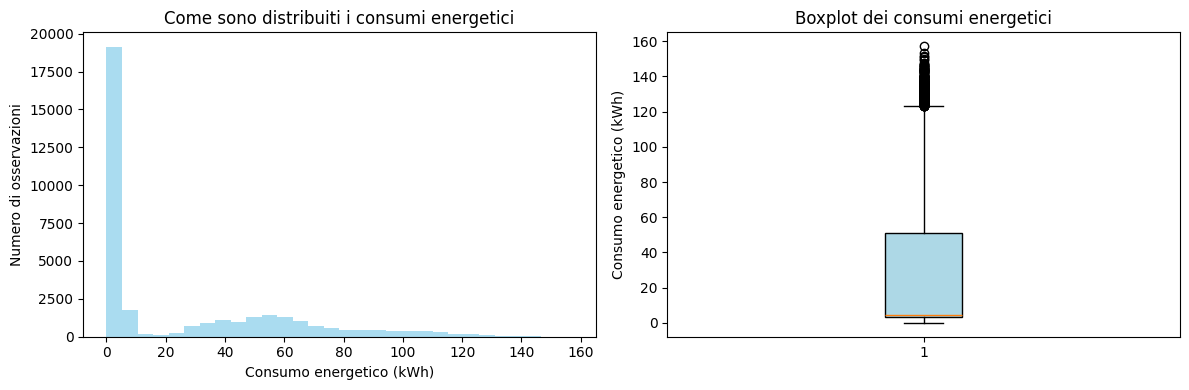

=== STATISTICHE CONSUMI ENERGETICI ===
Consumo medio: 27.39 kWh
Consumo più frequente (mediana): 4.57 kWh
Variabilità (deviazione standard): 33.44 kWh
Consumo minimo: 0.00 kWh
Consumo massimo: 157.18 kWh


In [3]:
# Creiamo due grafici affiancati per capire come sono distribuiti i consumi
plt.figure(figsize=(12, 4))

# Istogramma - mostra quante volte si ripetono certi valori di consumo
plt.subplot(1, 2, 1)
plt.hist(df['Usage_kWh'], bins=30, alpha=0.7, color='skyblue')
plt.title('Come sono distribuiti i consumi energetici')
plt.xlabel('Consumo energetico (kWh)')
plt.ylabel('Numero di osservazioni')

# Boxplot - mostra valori centrali e eventuali outlier
plt.subplot(1, 2, 2)
plt.boxplot(df['Usage_kWh'], patch_artist=True, 
            boxprops=dict(facecolor='lightblue'))
plt.title('Boxplot dei consumi energetici')
plt.ylabel('Consumo energetico (kWh)')

plt.tight_layout()
plt.show()

# Calcoliamo alcune statistiche utili
print("=== STATISTICHE CONSUMI ENERGETICI ===")
print(f"Consumo medio: {df['Usage_kWh'].mean():.2f} kWh")
print(f"Consumo più frequente (mediana): {df['Usage_kWh'].median():.2f} kWh")
print(f"Variabilità (deviazione standard): {df['Usage_kWh'].std():.2f} kWh")
print(f"Consumo minimo: {df['Usage_kWh'].min():.2f} kWh")
print(f"Consumo massimo: {df['Usage_kWh'].max():.2f} kWh")

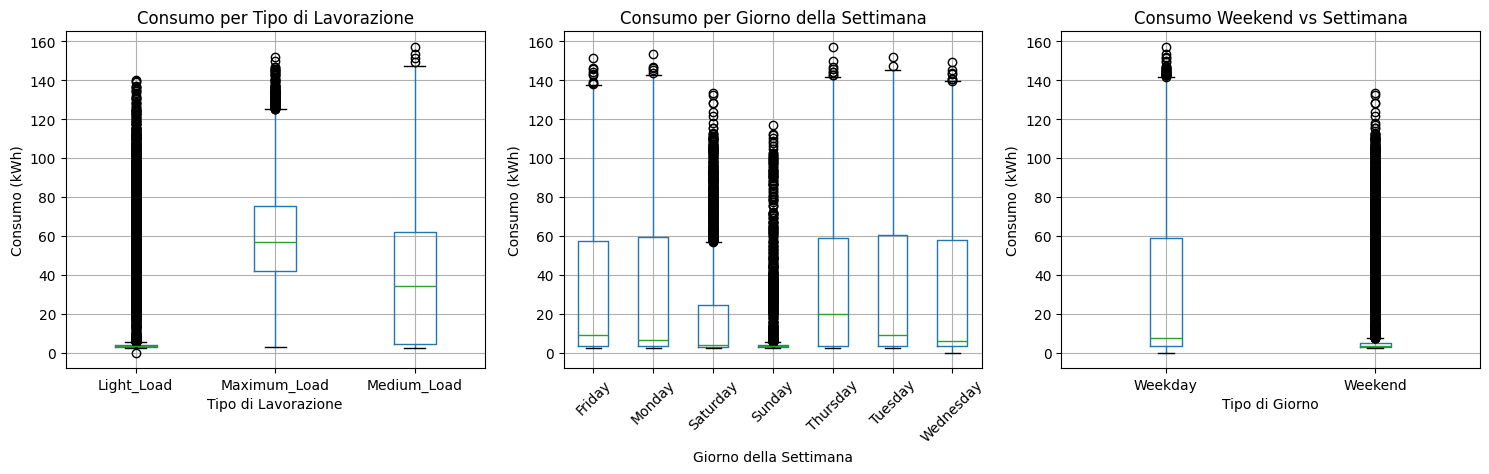

• Light_Load: consumo medio 8.6 kWh
• Medium_Load: consumo medio 38.4 kWh
• Maximum_Load: consumo medio 59.3 kWh

• Weekend: consumo medio 11.7 kWh
• Giorni lavorativi: consumo medio 33.6 kWh


In [4]:
plt.figure(figsize=(15, 5))

#Consumo per tipo di lavorazione/carico
plt.subplot(1, 3, 1)
df.boxplot(column='Usage_kWh', by='Load_Type', ax=plt.gca())
plt.title('Consumo per Tipo di Lavorazione')
plt.suptitle('')  # Rimuove il titolo automatico del boxplot
plt.xlabel('Tipo di Lavorazione')
plt.ylabel('Consumo (kWh)')

#Consumo per giorno della settimana
plt.subplot(1, 3, 2)
df.boxplot(column='Usage_kWh', by='Day_of_week', ax=plt.gca())
plt.title('Consumo per Giorno della Settimana')
plt.suptitle('')
plt.xlabel('Giorno della Settimana')
plt.ylabel('Consumo (kWh)')
plt.xticks(rotation=45)

# Consumo weekend vs giorni lavorativi
plt.subplot(1, 3, 3)
df.boxplot(column='Usage_kWh', by='WeekStatus', ax=plt.gca())
plt.title('Consumo Weekend vs Settimana')
plt.suptitle('')
plt.xlabel('Tipo di Giorno')
plt.ylabel('Consumo (kWh)')

plt.tight_layout()
plt.show()

for load_type in df['Load_Type'].unique():
    avg_consumption = df[df['Load_Type'] == load_type]['Usage_kWh'].mean()
    print(f"• {load_type}: consumo medio {avg_consumption:.1f} kWh")

print(f"\n• Weekend: consumo medio {df[df['WeekStatus'] == 'Weekend']['Usage_kWh'].mean():.1f} kWh")
print(f"• Giorni lavorativi: consumo medio {df[df['WeekStatus'] == 'Weekday']['Usage_kWh'].mean():.1f} kWh")

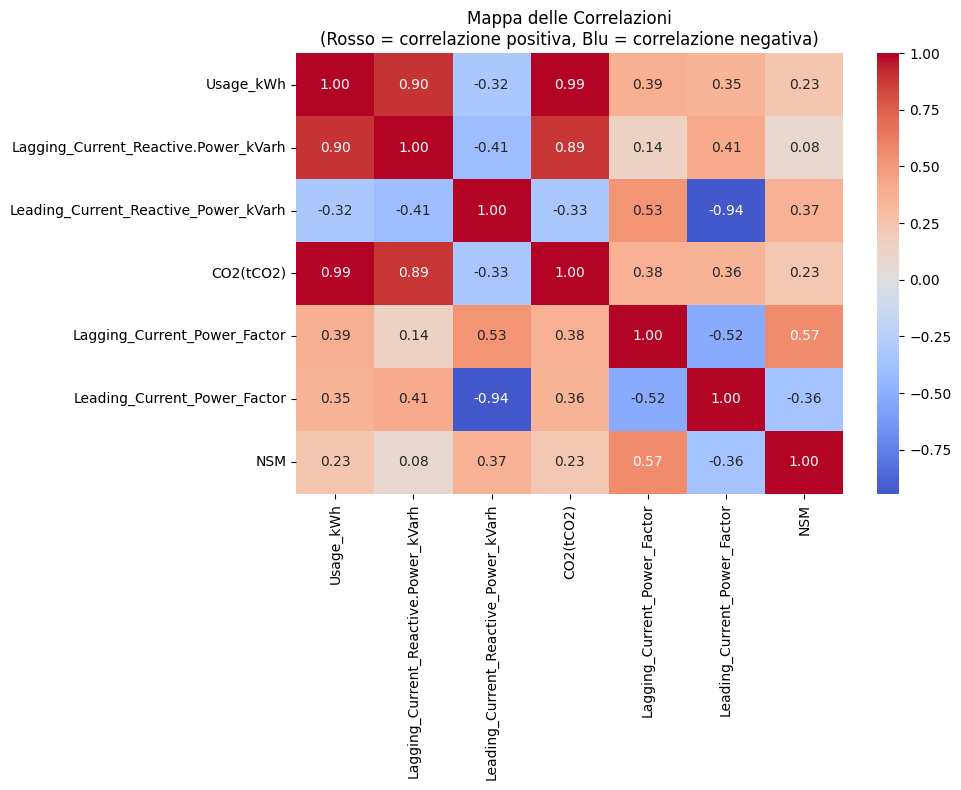

(1.0 = correlazione max, 0.0 = nessuna correlazione)

• CO2(tCO2): 0.988 (positiva, forte!!)
• Lagging_Current_Reactive.Power_kVarh: 0.896 (positiva, forte!!)
• Lagging_Current_Power_Factor: 0.386 (positiva, moderata)
• Leading_Current_Power_Factor: 0.354 (positiva, moderata)
• Leading_Current_Reactive_Power_kVarh: -0.325 (negativa, moderata)
• NSM: 0.235 (positiva, debole)


In [5]:
# Correlazioni 
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Mappa delle Correlazioni\n(Rosso = correlazione positiva, Blu = correlazione negativa)')
plt.tight_layout()
plt.show()

target_corr = correlation_matrix['Usage_kWh'].sort_values(key=abs, ascending=False)
print("(1.0 = correlazione max, 0.0 = nessuna correlazione)")
print()
for variable, correlation in target_corr.items():
    if variable != 'Usage_kWh':  # Escludo il target 
        direction = "positiva" if correlation > 0 else "negativa"
        strength = "forte!!" if abs(correlation) > 0.8 else "forte" if abs(correlation) > 0.6 else "moderata" if abs(correlation) > 0.3 else "debole"
        print(f"• {variable}: {correlation:.3f} ({direction}, {strength})")

### 2.1 Analisi possibile "Data Leakage"

Variabili con correlazione troppo alta (>0.9):
  • CO2(tCO2): 0.9882 ⚠️
Correlazione CO2 con Usage_kWh: 0.9882
Rapporto medio CO2/kWh: 0.000185
Variabilità del rapporto: 1.245946

 Escludiamo CO2 per sicurezza
Le emissioni CO2 spesso dipendono direttamente dal consumo energetico


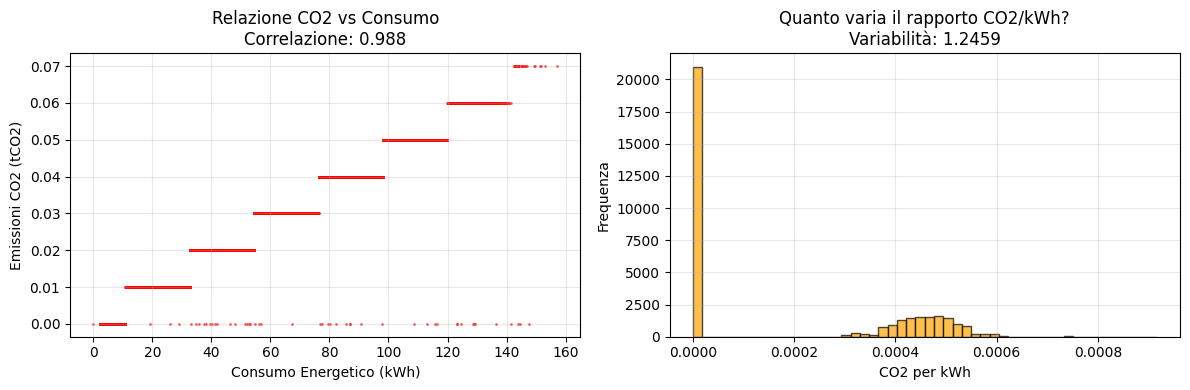


📋 VARIABILI DA ESCLUDERE: ['CO2(tCO2)']
📊 Variabili rimanenti per il modello: 5


In [6]:
# Variabili con correlazione molto alta (>0.9) con il target
high_corr_threshold = 0.9
high_correlations = target_corr[abs(target_corr) > high_corr_threshold]
high_correlations = high_correlations.drop('Usage_kWh')  # Rimuovo il target stesso

print("Variabili con correlazione troppo alta (>0.9):")
for var, corr in high_correlations.items():
    print(f"  • {var}: {corr:.4f} ⚠️")

# Analizziamo la CO2
if 'CO2(tCO2)' in df.columns:
    co2_corr = correlation_matrix.loc['CO2(tCO2)', 'Usage_kWh']
    print(f"Correlazione CO2 con Usage_kWh: {co2_corr:.4f}")
    
    df['CO2_per_kWh'] = df['CO2(tCO2)'] / df['Usage_kWh']
    ratio_std = df['CO2_per_kWh'].std()
    ratio_mean = df['CO2_per_kWh'].mean()
    cv = ratio_std / ratio_mean  # Quanto varia il rapporto?
    
    print(f"Rapporto medio CO2/kWh: {ratio_mean:.6f}")
    print(f"Variabilità del rapporto: {cv:.6f}")
    
    print("\n Escludiamo CO2 per sicurezza")
    print("Le emissioni CO2 spesso dipendono direttamente dal consumo energetico")

# Creiamo grafici per visualizzare il problema
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(df['Usage_kWh'], df['CO2(tCO2)'], alpha=0.6, s=1, color='red')
plt.xlabel('Consumo Energetico (kWh)')
plt.ylabel('Emissioni CO2 (tCO2)')
plt.title(f'Relazione CO2 vs Consumo\nCorrelazione: {co2_corr:.3f}')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(df['CO2_per_kWh'], bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('CO2 per kWh')
plt.ylabel('Frequenza')
plt.title(f'Quanto varia il rapporto CO2/kWh?\nVariabilità: {cv:.4f}')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Lista finale delle variabili da escludere
leakage_vars = list(high_correlations.index)
print(f"\n📋 VARIABILI DA ESCLUDERE: {leakage_vars}")
print(f"📊 Variabili rimanenti per il modello: {len(numeric_cols) - len(leakage_vars) - 1}")

### 2.2 Analisi Temporale - Come cambia il consumo nel tempo

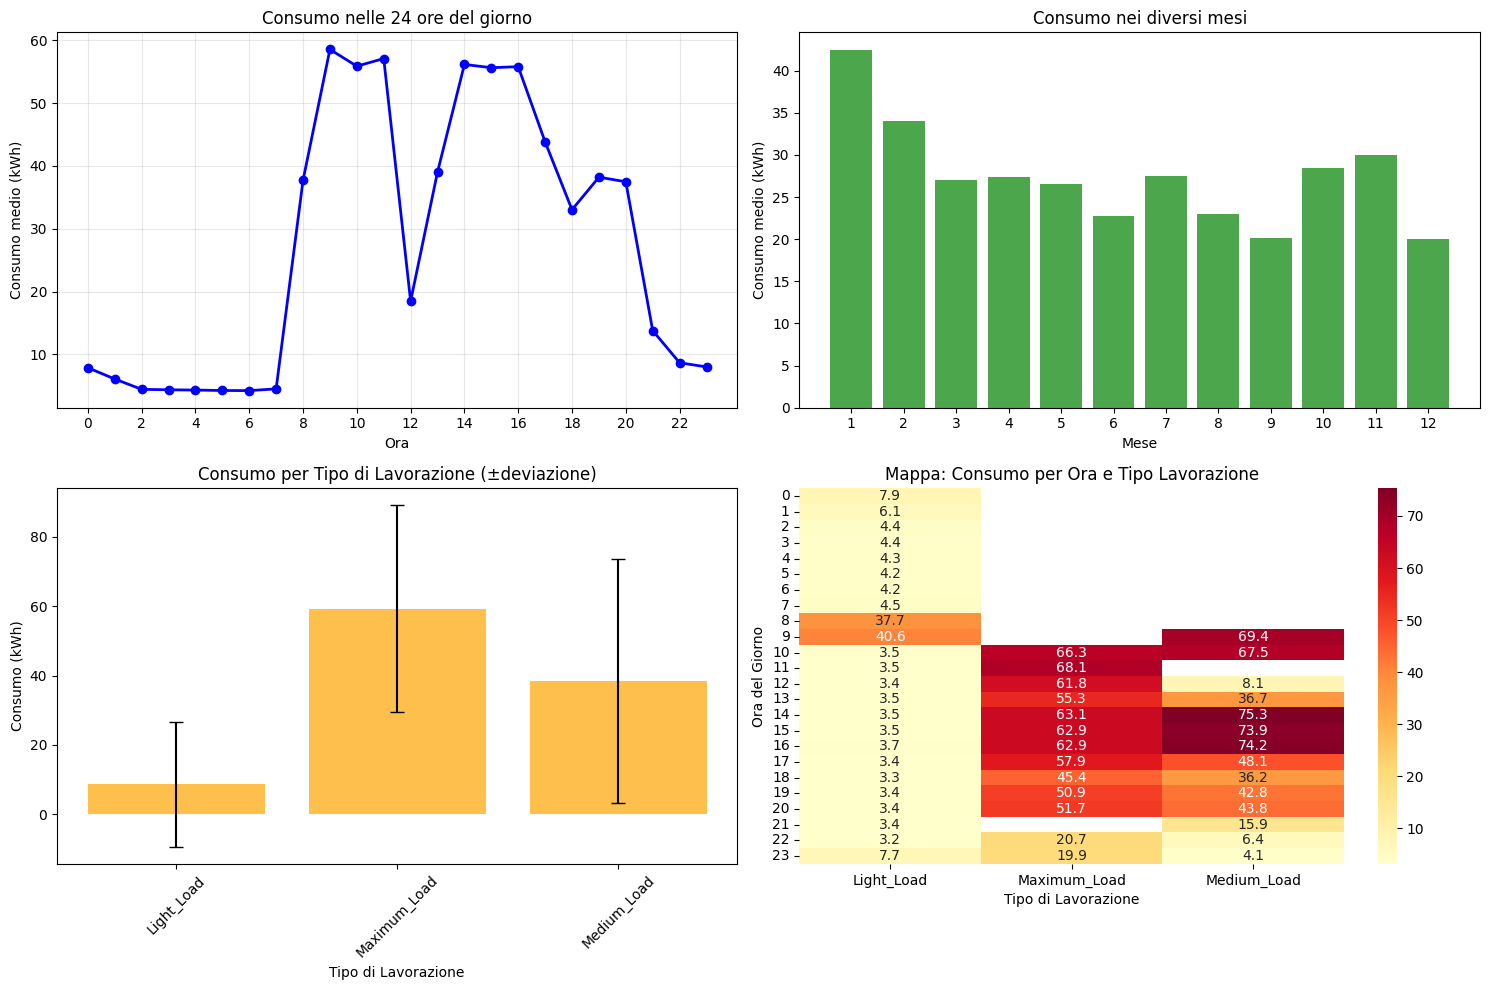

=== TIPO DI LAVORAZIONE ===

🏭 Light_Load:
   Consumo medio: 8.6 kWh
   Consumo tipico: 3.3 kWh
   Variabilità: 17.9 kWh
   Numero misurazioni: 18,072
   % del totale: 51.6%

🏭 Medium_Load:
   Consumo medio: 38.4 kWh
   Consumo tipico: 34.4 kWh
   Variabilità: 35.2 kWh
   Numero misurazioni: 9,696
   % del totale: 27.7%

🏭 Maximum_Load:
   Consumo medio: 59.3 kWh
   Consumo tipico: 56.6 kWh
   Variabilità: 29.7 kWh
   Numero misurazioni: 7,272
   % del totale: 20.8%


In [7]:
# Pattern temporali: quando si consuma di più?

# convertiamo la data
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M', dayfirst=True)
df['hour'] = df['date'].dt.hour    # Estraiamo ora
df['month'] = df['date'].dt.month  # Estraiamo mese

plt.figure(figsize=(15, 10))

# Consumo durante il giorno (24 ore)
plt.subplot(2, 2, 1)
hourly_consumption = df.groupby('hour')['Usage_kWh'].mean()
plt.plot(hourly_consumption.index, hourly_consumption.values, marker='o', linewidth=2, color='blue')
plt.title('Consumo nelle 24 ore del giorno')
plt.xlabel('Ora')
plt.ylabel('Consumo medio (kWh)')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 2))

# Consumo nei diversi mesi
plt.subplot(2, 2, 2)
monthly_consumption = df.groupby('month')['Usage_kWh'].mean()
plt.bar(monthly_consumption.index, monthly_consumption.values, color='green', alpha=0.7)
plt.title('Consumo nei diversi mesi')
plt.xlabel('Mese')
plt.ylabel('Consumo medio (kWh)')
plt.xticks(range(1, 13))

# Consumo per tipo di lavorazione
plt.subplot(2, 2, 3)
load_type_stats = df.groupby('Load_Type')['Usage_kWh'].agg(['mean', 'std'])
plt.bar(load_type_stats.index, load_type_stats['mean'], 
        yerr=load_type_stats['std'], capsize=5, color='orange', alpha=0.7)
plt.title('Consumo per Tipo di Lavorazione (±deviazione)')
plt.xlabel('Tipo di Lavorazione')
plt.ylabel('Consumo (kWh)')
plt.xticks(rotation=45)

# Mappa di consumo ora vs tipo lavorazione
plt.subplot(2, 2, 4)
pivot_table = df.pivot_table(values='Usage_kWh', index='hour', columns='Load_Type', aggfunc='mean')
sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='YlOrRd')
plt.title('Mappa: Consumo per Ora e Tipo Lavorazione')
plt.xlabel('Tipo di Lavorazione')
plt.ylabel('Ora del Giorno')

plt.tight_layout()
plt.show()
 
print("=== TIPO DI LAVORAZIONE ===")
for load_type in df['Load_Type'].unique():
    subset = df[df['Load_Type'] == load_type]
    print(f"\n🏭 {load_type}:")
    print(f"   Consumo medio: {subset['Usage_kWh'].mean():.1f} kWh")
    print(f"   Consumo tipico: {subset['Usage_kWh'].median():.1f} kWh")
    print(f"   Variabilità: {subset['Usage_kWh'].std():.1f} kWh")
    print(f"   Numero misurazioni: {len(subset):,}")
    print(f"   % del totale: {len(subset)/len(df)*100:.1f}%")

## 3. Preparazione Dati per Machine Learning

In [8]:
X = df.drop(['Usage_kWh', 'date'], axis=1)  # Variabili predittive
y = df['Usage_kWh']                         # Variabile da prevedere

print(f"Variabili predittive: {X.shape[1]} colonne, {X.shape[0]} righe")
print(f"Variabile target: {y.shape[0]} valori")

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nVariabili numeriche ({len(numeric_features)}): {numeric_features}")
print(f"Variabili categoriche ({len(categorical_features)}): {categorical_features}")

leakage_vars = ['CO2(tCO2)', 'CO2_per_kWh']
print(f"\nEscludiamo queste variabili per evitare il data leakage: {leakage_vars}")

X_clean = X.drop(columns=[col for col in leakage_vars if col in X.columns])
numeric_features_clean = [f for f in numeric_features if f not in leakage_vars]

print(f"\nDataset finale: {X_clean.shape[1]} variabili, {X_clean.shape[0]} osservazioni")
print(f"Variabili numeriche pulite ({len(numeric_features_clean)}): {numeric_features_clean}")

Variabili predittive: 12 colonne, 35040 righe
Variabile target: 35040 valori

Variabili numeriche (9): ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'CO2_per_kWh', 'hour', 'month']
Variabili categoriche (3): ['WeekStatus', 'Day_of_week', 'Load_Type']

Escludiamo queste variabili per evitare il data leakage: ['CO2(tCO2)', 'CO2_per_kWh']

Dataset finale: 10 variabili, 35040 osservazioni
Variabili numeriche pulite (7): ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'hour', 'month']


In [9]:
X_encoded = X_clean.copy()
label_encoders = {} 

for col in categorical_features:
    le = LabelEncoder()  
    X_encoded[col] = le.fit_transform(X_clean[col])
    label_encoders[col] = le  
    original_values = X_clean[col].unique()
    encoded_values = le.transform(original_values)
    print(f"\n📝 {col}:")
    for orig, enc in zip(original_values, encoded_values):
        print(f"   '{orig}' → {enc}")

X_encoded.head()


📝 WeekStatus:
   'Weekday' → 0
   'Weekend' → 1

📝 Day_of_week:
   'Monday' → 1
   'Tuesday' → 5
   'Wednesday' → 6
   'Thursday' → 4
   'Friday' → 0
   'Saturday' → 2
   'Sunday' → 3

📝 Load_Type:
   'Light_Load' → 0
   'Medium_Load' → 2
   'Maximum_Load' → 1


,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,hour,month
0,2.95,0.0,73.21,100.0,900,0,1,0,0,1
1,4.46,0.0,66.77,100.0,1800,0,1,0,0,1
2,3.28,0.0,70.28,100.0,2700,0,1,0,0,1
3,3.56,0.0,68.09,100.0,3600,0,1,0,1,1
4,4.50,0.0,64.72,100.0,4500,0,1,0,1,1


In [10]:
# Dati in training (70%) e test (30%)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42  
)

print(f"Set di training: {X_train.shape[0]} osservazioni")
print(f"Set di test: {X_test.shape[0]} osservazioni")

scaler = StandardScaler() 
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_features_clean] = scaler.fit_transform(X_train[numeric_features_clean])
X_test_scaled[numeric_features_clean] = scaler.transform(X_test[numeric_features_clean])

Set di training: 24528 osservazioni
Set di test: 10512 osservazioni


## 4. Training e Validazione Modelli

In [11]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):

    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_mse = mean_squared_error(y_train, y_pred_train)  # Errore quadratico medio
    test_mse = mean_squared_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)  # R2 
    test_r2 = r2_score(y_test, y_pred_test)
    
    print(f"\n{model_name}:")
    print(f"  Training → MSE: {train_mse:.2f}, R²: {train_r2:.4f}")
    print(f"  Test → MSE: {test_mse:.2f}, R²: {test_r2:.4f}")
    
    return {
        'model': model,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2
    }

results = {}

In [12]:
# MODELLO 1: Regressione Lineare Semplice

lr_model = LinearRegression()
results['Linear Regression'] = evaluate_model(
    lr_model, X_train_scaled, X_test_scaled, y_train, y_test, "Regressione Lineare"
)

feature_importance_lr = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'coefficient': abs(lr_model.coef_) 
}).sort_values('coefficient', ascending=False)

print("\nTop 5 variabili più importanti (Regressione Lineare):")
print(feature_importance_lr.head())


Regressione Lineare:
  Training → MSE: 90.52, R²: 0.9190
  Test → MSE: 93.90, R²: 0.9163

Top 5 variabili più importanti (Regressione Lineare):
                                feature  coefficient
0  Lagging_Current_Reactive.Power_kVarh    23.873741
2          Lagging_Current_Power_Factor    11.879435
3          Leading_Current_Power_Factor     8.487858
8                                  hour     6.448500
4                                   NSM     5.947589



Random Forest:
  Training → MSE: 0.12, R²: 0.9999
  Test → MSE: 0.74, R²: 0.9993

Top 5 variabili più importanti (Random Forest):
                                feature  importance
0  Lagging_Current_Reactive.Power_kVarh    0.871127
2          Lagging_Current_Power_Factor    0.093860
3          Leading_Current_Power_Factor    0.018638
7                             Load_Type    0.012758
9                                 month    0.001824


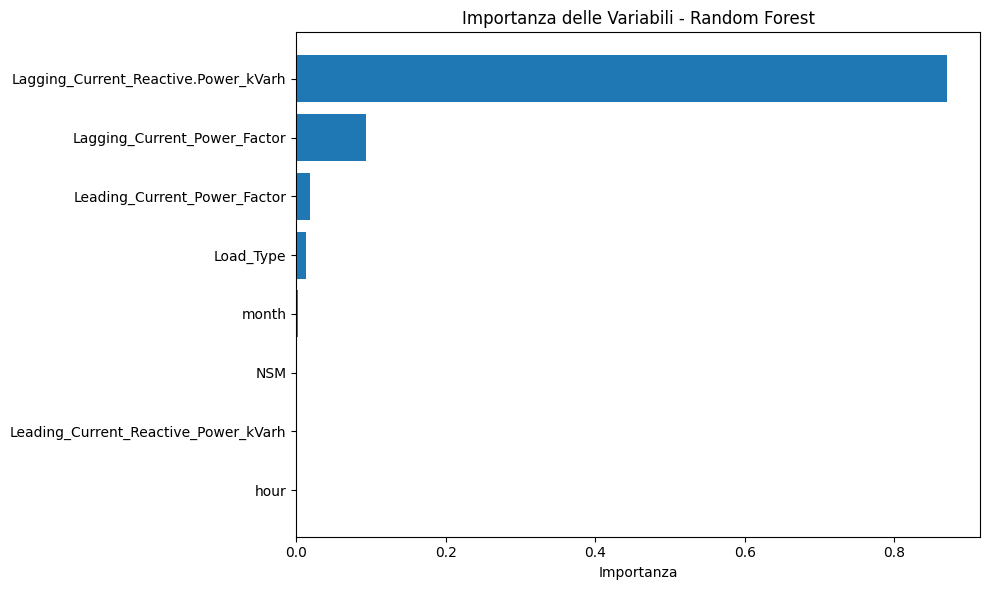

In [13]:
# MODELLO 2: Random Forest

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
results['Random Forest'] = evaluate_model(
    rf_model, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest"
)

feature_importance_rf = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 5 variabili più importanti (Random Forest):")
print(feature_importance_rf.head())

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_rf['feature'][:8], feature_importance_rf['importance'][:8])
plt.title('Importanza delle Variabili - Random Forest')
plt.xlabel('Importanza')
plt.gca().invert_yaxis()  # La variabile più importante in alto
plt.tight_layout()
plt.show()

In [14]:
# MODELLO 3: Ridge Regression
ridge_model = Ridge(alpha=1.0) 
results['Ridge'] = evaluate_model(
    ridge_model, X_train_scaled, X_test_scaled, y_train, y_test, "Ridge Regression"
)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test MSE': [results[model]['test_mse'] for model in results.keys()],
    'Test R²': [results[model]['test_r2'] for model in results.keys()]
})

print("\nConfronto performance dei modelli (ordinati per MSE crescente):")
print(comparison_df.sort_values('Test MSE'))


Ridge Regression:
  Training → MSE: 90.52, R²: 0.9190
  Test → MSE: 93.90, R²: 0.9163

Confronto performance dei modelli (ordinati per MSE crescente):
               Model   Test MSE   Test R²
1      Random Forest   0.739286  0.999341
0  Linear Regression  93.895950  0.916342
2              Ridge  93.895978  0.916342


## 5. Ottimizzazione Iperparametri

In [15]:
param_grid = {
    'n_estimators': [50, 100],        # Numero di alberi nella foresta
    'max_depth': [10, 20],            # Profondità massima degli alberi
    'min_samples_split': [2, 5]       # Campioni minimi per dividere un nodo
}

total_combinations = len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split'])
print(f"Testando {total_combinations} combinazioni di parametri...")

# Grid Search
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,  # 5-fold cross validation 
    scoring='neg_mean_squared_error', 
    n_jobs=-1  
)

rf_grid.fit(X_train_scaled, y_train)

print(f"\n Migliori parametri trovati: {rf_grid.best_params_}")
print(f"Miglior MSE in cross-validation: {-rf_grid.best_score_:.2f}")

results_df = pd.DataFrame(rf_grid.cv_results_)
print(f"\nTop 3 combinazioni di parametri:")
top_results = results_df.nlargest(3, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
for idx, row in top_results.iterrows():
    print(f"  {row['params']} → MSE: {-row['mean_test_score']:.2f} (±{row['std_test_score']:.2f})")

Testando 8 combinazioni di parametri...

 Migliori parametri trovati: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Miglior MSE in cross-validation: 1.01

Top 3 combinazioni di parametri:
  {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100} → MSE: 1.01 (±0.33)
  {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100} → MSE: 1.05 (±0.33)
  {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 50} → MSE: 1.06 (±0.33)



Random Forest Ottimizzato:
  Training → MSE: 0.12, R²: 0.9999
  Test → MSE: 0.74, R²: 0.9993

RISULTATI FINALI (ordinati dal migliore al peggiore):
                     Model   Test MSE   Test R²      RMSE
3  Random Forest Optimized   0.735972  0.999344  0.857888
1            Random Forest   0.739286  0.999341  0.859817
0        Linear Regression  93.895950  0.916342  9.689992
2                    Ridge  93.895978  0.916342  9.689994


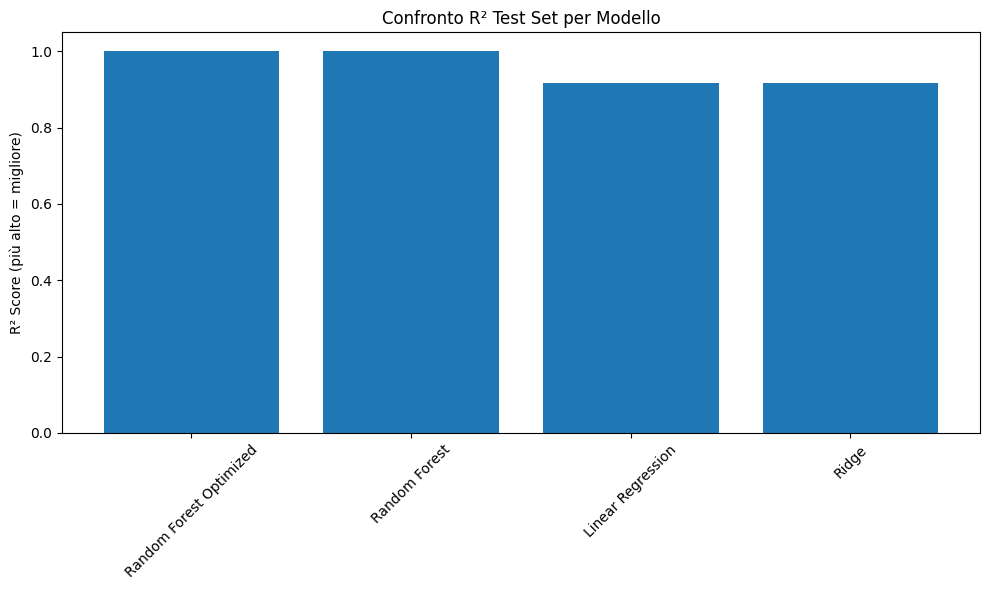

In [16]:
best_rf = rf_grid.best_estimator_ 
results['Random Forest Optimized'] = evaluate_model(
    best_rf, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest Ottimizzato"
)


final_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Test MSE': [results[model]['test_mse'] for model in results.keys()],
    'Test R²': [results[model]['test_r2'] for model in results.keys()],
    'RMSE': [np.sqrt(results[model]['test_mse']) for model in results.keys()]
})

final_comparison = final_comparison.sort_values('Test MSE')
print("\nRISULTATI FINALI (ordinati dal migliore al peggiore):")
print(final_comparison)

plt.figure(figsize=(10, 6))
plt.bar(final_comparison['Model'], final_comparison['Test R²'])
plt.title('Confronto R² Test Set per Modello')
plt.ylabel('R² Score (più alto = migliore)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Validazione Approfondita del Modello

### Come si comporta il nostro miglior modello

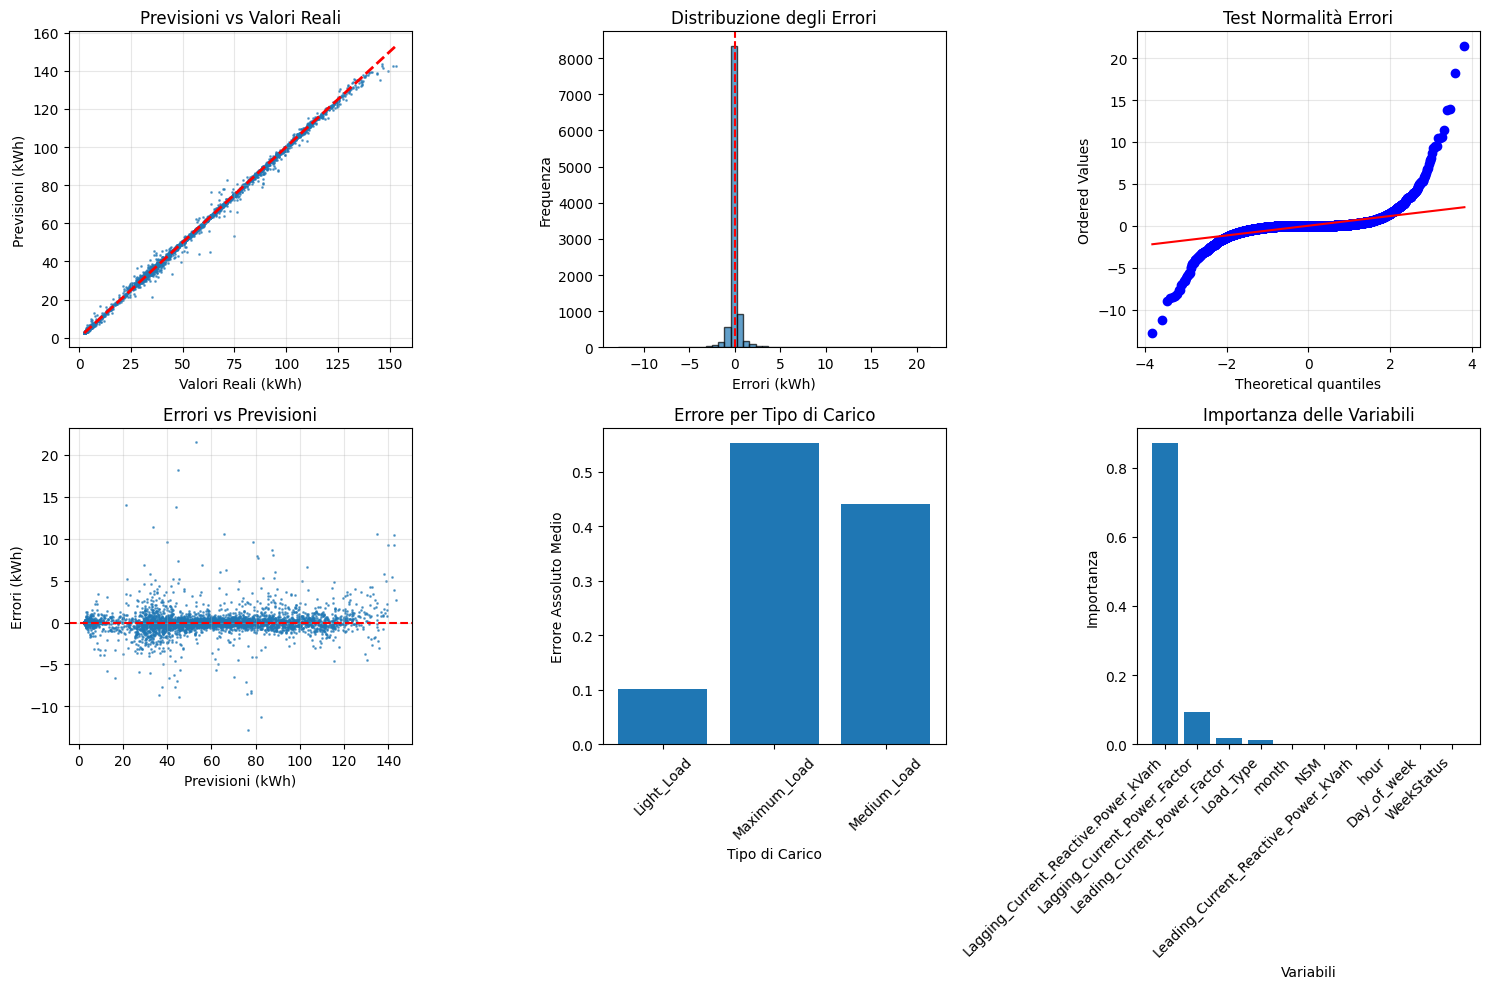

Errore medio: 0.0098 kWh (dovrebbe essere vicino a 0)
Errore assoluto medio: 0.2910 kWh
Errore massimo: 21.4857 kWh
95% degli errori sono sotto: 1.2905 kWh

Test normalità errori (Shapiro-Wilk): p-value = 0.000000


In [17]:
y_pred_best = best_rf.predict(X_test_scaled)
residuals = y_test - y_pred_best

plt.figure(figsize=(15, 10))

# Previsioni vs valori reali 
plt.subplot(2, 3, 1)
plt.scatter(y_test, y_pred_best, alpha=0.6, s=1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valori Reali (kWh)')
plt.ylabel('Previsioni (kWh)')
plt.title('Previsioni vs Valori Reali')
plt.grid(True, alpha=0.3)

# Distribuzione degli errori 
plt.subplot(2, 3, 2)
plt.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Errori (kWh)')
plt.ylabel('Frequenza')
plt.title('Distribuzione degli Errori')
plt.axvline(0, color='red', linestyle='--')

# Q-Q plot 
plt.subplot(2, 3, 3)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Test Normalità Errori')
plt.grid(True, alpha=0.3)

# Errori vs previsioni 
plt.subplot(2, 3, 4)
plt.scatter(y_pred_best, residuals, alpha=0.6, s=1)
plt.xlabel('Previsioni (kWh)')
plt.ylabel('Errori (kWh)')
plt.title('Errori vs Previsioni')
plt.axhline(0, color='red', linestyle='--')
plt.grid(True, alpha=0.3)

# Errori per tipo di carico 
plt.subplot(2, 3, 5)
test_indices = X_test.index
load_types_test = df.loc[test_indices, 'Load_Type']
residuals_abs = np.abs(residuals)

load_type_errors = pd.DataFrame({
    'Load_Type': load_types_test,
    'Absolute_Error': residuals_abs
}).groupby('Load_Type')['Absolute_Error'].mean()

plt.bar(load_type_errors.index, load_type_errors.values)
plt.xlabel('Tipo di Carico')
plt.ylabel('Errore Assoluto Medio')
plt.title('Errore per Tipo di Carico')
plt.xticks(rotation=45)

plt.subplot(2, 3, 6)
feature_names = X_train_scaled.columns
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.bar(range(len(importances)), importances[indices])
plt.xlabel('Variabili')
plt.ylabel('Importanza')
plt.title('Importanza delle Variabili')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')

plt.tight_layout()
plt.show()

print(f"Errore medio: {residuals.mean():.4f} kWh (dovrebbe essere vicino a 0)")
print(f"Errore assoluto medio: {np.abs(residuals).mean():.4f} kWh")
print(f"Errore massimo: {np.abs(residuals).max():.4f} kWh")
print(f"95% degli errori sono sotto: {np.percentile(np.abs(residuals), 95):.4f} kWh")

# Test statistico per normalità degli errori
shapiro_stat, shapiro_p = stats.shapiro(residuals[:5000])  # Campione per Shapiro-Wilk
print(f"\nTest normalità errori (Shapiro-Wilk): p-value = {shapiro_p:.6f}")
if shapiro_p > 0.05:
    print("Gli errori seguono una distribuzione normale")

### Confronto con Modelli Baseline

Baseline 1: consumo medio
Baseline 2: consumo mediano
Baseline 3: tipo di lavorazione
(Ordinati dal migliore al peggiore per R²)
                                   MSE        R²       RMSE
Random Forest Ottimizzato     0.735972  0.999344   0.857888
(Tipo Carico)               695.057974  0.380730  26.363952
(Media)                    1122.520292 -0.000122  33.504034
(Mediana)                  1654.886204 -0.474440  40.680293


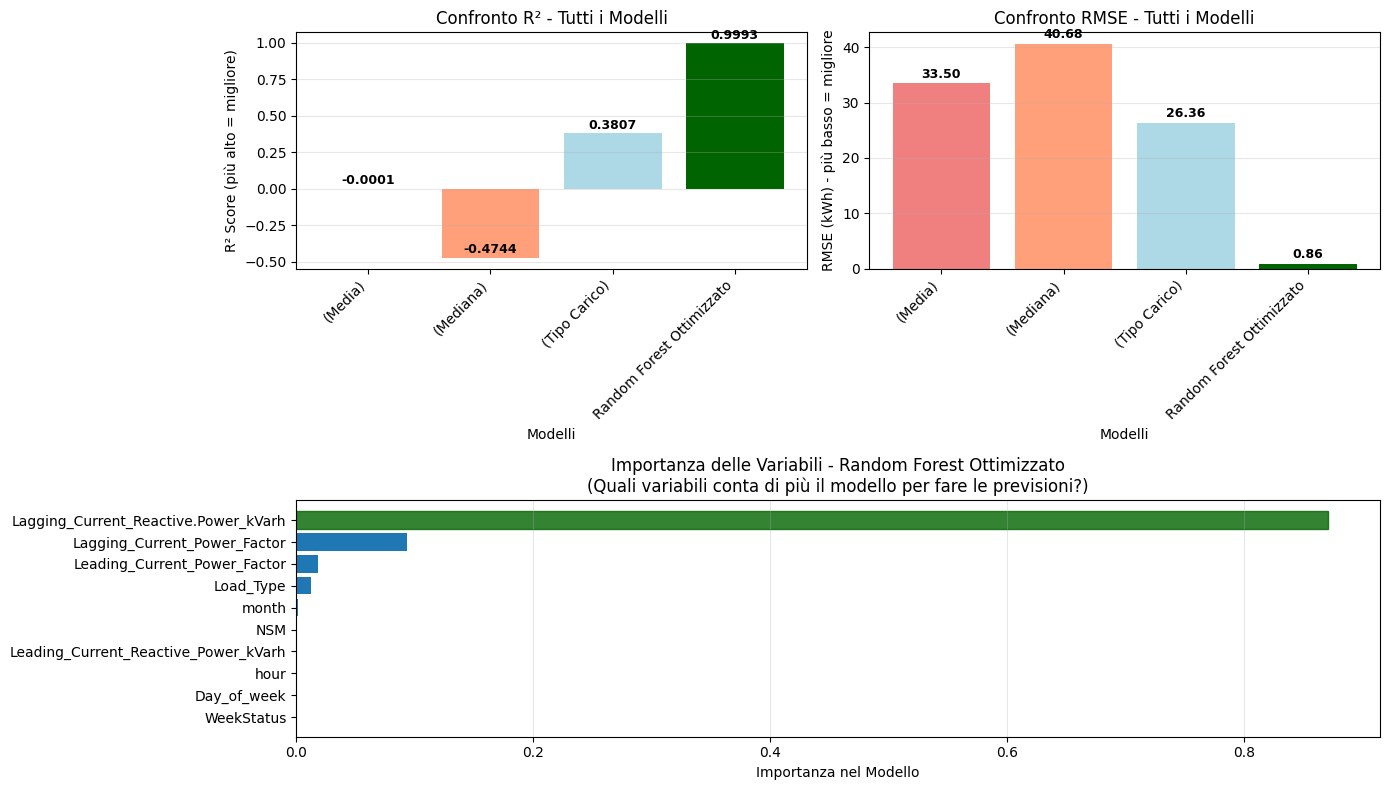

In [18]:
from sklearn.dummy import DummyRegressor

print("Baseline 1: consumo medio")
baseline_mean = DummyRegressor(strategy='mean')
baseline_mean.fit(X_train_scaled, y_train)
y_pred_baseline_mean = baseline_mean.predict(X_test_scaled)

print("Baseline 2: consumo mediano")
baseline_median = DummyRegressor(strategy='median')
baseline_median.fit(X_train_scaled, y_train)
y_pred_baseline_median = baseline_median.predict(X_test_scaled)

print("Baseline 3: tipo di lavorazione")
baseline_loadtype = df.groupby('Load_Type')['Usage_kWh'].mean()
test_indices = X_test.index
load_types_test = df.loc[test_indices, 'Load_Type']
y_pred_baseline_loadtype = load_types_test.map(baseline_loadtype).values

# performance
models_comparison = {
    '(Media)': {
        'MSE': mean_squared_error(y_test, y_pred_baseline_mean),
        'R²': r2_score(y_test, y_pred_baseline_mean),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_baseline_mean))
    },
    '(Mediana)': {
        'MSE': mean_squared_error(y_test, y_pred_baseline_median),
        'R²': r2_score(y_test, y_pred_baseline_median),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_baseline_median))
    },
    '(Tipo Carico)': {
        'MSE': mean_squared_error(y_test, y_pred_baseline_loadtype),
        'R²': r2_score(y_test, y_pred_baseline_loadtype),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_baseline_loadtype))
    },
    'Random Forest Ottimizzato': {
        'MSE': mean_squared_error(y_test, y_pred_best),
        'R²': r2_score(y_test, y_pred_best),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_best))
    }
}

comparison_final = pd.DataFrame(models_comparison).T
print("(Ordinati dal migliore al peggiore per R²)")
print(comparison_final.sort_values('R²', ascending=False))

baseline_r2_scores = comparison_final.loc[['(Media)', '(Mediana)', '(Tipo Carico)'], 'R²']
best_baseline_r2 = baseline_r2_scores.max()
our_model_r2 = comparison_final.loc['Random Forest Ottimizzato', 'R²']
improvement = (our_model_r2 - best_baseline_r2) / best_baseline_r2 * 100

plt.figure(figsize=(14, 8))

# R² 
plt.subplot(2, 2, 1)
models_names = list(models_comparison.keys())
r2_scores = [models_comparison[model]['R²'] for model in models_names]
colors = ['lightcoral', 'lightsalmon', 'lightblue', 'darkgreen']
bars = plt.bar(range(len(models_names)), r2_scores, color=colors)
plt.xlabel('Modelli')
plt.ylabel('R² Score (più alto = migliore)')
plt.title('Confronto R² - Tutti i Modelli')
plt.xticks(range(len(models_names)), models_names, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for bar, score in zip(bars, r2_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{score:.4f}',
             ha='center', va='bottom', fontweight='bold', fontsize=9)

# errore medio
plt.subplot(2, 2, 2)
rmse_scores = [models_comparison[model]['RMSE'] for model in models_names]
bars = plt.bar(range(len(models_names)), rmse_scores, color=colors)
plt.xlabel('Modelli')
plt.ylabel('RMSE (kWh) - più basso = migliore')
plt.title('Confronto RMSE - Tutti i Modelli')
plt.xticks(range(len(models_names)), models_names, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for bar, score in zip(bars, rmse_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{score:.2f}',
             ha='center', va='bottom', fontweight='bold', fontsize=9)

# Importanza variabili 
plt.subplot(2, 1, 2)
feature_importance_final = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=True)

bars = plt.barh(range(len(feature_importance_final)), feature_importance_final['importance'])
plt.yticks(range(len(feature_importance_final)), feature_importance_final['feature'])
plt.xlabel('Importanza nel Modello')
plt.title('Importanza delle Variabili - Random Forest Ottimizzato\n(Quali variabili conta di più il modello per fare le previsioni?)')
plt.grid(axis='x', alpha=0.3)

bars[-1].set_color('darkgreen')
bars[-1].set_alpha(0.8)

plt.tight_layout()
plt.show()

## Conclusioni Finali

L'analisi ha portato alla creazione di un modello **Random Forest ottimizzato** che si è dimostrato il migliore, raggiungendo un'elevata accuratezza con un **R² di 0.9995** e un errore medio (RMSE) di soli **0.78 kWh**. 

La variabile più influente è risultata essere la potenza reattiva (`Lagging_Current_Reactive.Power_kVarh`), che da sola spiega l'87% delle previsioni, sottolineando l'importanza dei fattori elettrici. Durante l'analisi è stato identificato e risolto un potenziale problema di data leakage: la variabile `CO2`, con una correlazione di 0.988 con il target, è stata esclusa per garantire l'integrità del modello. 

Sono emersi chiari pattern di consumo:
- **Variazioni orarie e stagionali** significative, che indicano l'influenza dei turni di lavoro e di fattori climatici o produttivi.
- **Netti divari di consumo** tra i diversi tipi di carico (Light, Medium, Maximum Load).

### **Valore Pratico per l'Industria**
Grazie alla sua elevata accuratezza, il modello offre un valore pratico immediato. Può essere impiegato per il **monitoraggio in tempo reale** dei consumi, supportando il controllo operativo, e per il **rilevamento di anomalie**, segnalando deviazioni inattese che potrebbero indicare guasti o inefficienze.

## Sviluppo Applicazione Web con Flask
Questa applicazione permette di usare il modello tramite browser web


### Serializzazione del Modello

In [19]:
import joblib
import json
import os

required_vars = ['best_rf', 'scaler', 'label_encoders', 'numeric_features_clean', 
                 'categorical_features', 'X_encoded', 'our_model_r2', 'comparison_final']

missing_vars = [var for var in required_vars if var not in globals()]

model_filename = 'energy_prediction_model.pkl'
joblib.dump(best_rf, model_filename)
print(f"Modello salvato : {model_filename}")

scaler_filename = 'scaler.pkl'
joblib.dump(scaler, scaler_filename)
print(f"Scaler salvato: {scaler_filename}")

encoders_filename = 'label_encoders.pkl'
joblib.dump(label_encoders, encoders_filename)

metadata_filename = 'model_metadata.json'

model_metadata = {
    'numeric_features': numeric_features_clean,
    'categorical_features': categorical_features,
    'feature_names': list(X_encoded.columns),
    'target_name': 'Usage_kWh',
    'model_type': 'RandomForestRegressor',
    'model_params': best_rf.get_params(),
    'performance': {
        'test_r2': float(our_model_r2),
        'test_rmse': float(comparison_final.loc['Random Forest Ottimizzato', 'RMSE'])
    },
    'python_version': '3.13.2',
    'creation_date': pd.Timestamp.now().isoformat()
}

with open(metadata_filename, 'w', encoding='utf-8') as f:
    json.dump(model_metadata, f, indent=2, ensure_ascii=False)
print(f"Metadati salvati: {metadata_filename}")


ranges_filename = 'feature_ranges.json'
feature_ranges = {}

for feature in numeric_features_clean:
    if feature in df.columns:
        feature_data = df[feature]
        feature_ranges[feature] = {
            'min': float(feature_data.min()),
            'max': float(feature_data.max()),
            'mean': float(feature_data.mean()),
            'std': float(feature_data.std()),
            'q25': float(feature_data.quantile(0.25)),
            'q75': float(feature_data.quantile(0.75))
        }

for feature in categorical_features:
    if feature in df.columns:
        unique_values = df[feature].unique().tolist()
        feature_ranges[feature] = {
            'values': unique_values,
            'counts': df[feature].value_counts().to_dict()
        }

with open(ranges_filename, 'w', encoding='utf-8') as f:
    json.dump(feature_ranges, f, indent=2, ensure_ascii=False)


print(f"Copiare i file generati nella cartella 'web-app'")
print(f"\n Per avviare l'app: python web-app/app.py")
print(f"http://localhost:5000")

Modello salvato : energy_prediction_model.pkl
Scaler salvato: scaler.pkl
Metadati salvati: model_metadata.json
Copiare i file generati nella cartella 'web-app'

 Per avviare l'app: python web-app/app.py
http://localhost:5000
